In [1]:
import sys

from PIL.JpegImagePlugin import JpegImageFile
from sympy.physics.control.control_plots import matplotlib

sys.path.append("..")
from flame_analysis_model import *

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


In [3]:
# ===== Load data =====
df = pd.read_csv("extracted_flame_front_16.csv")
df = df[(df['x'] > 125) & (df['x'] < 135)]

## Compare K means on chemical composition vs reaction rates

[State-space features (φ)] Centroids in original feature units:
 [[2.65571940e-03 1.25496958e-01 1.17646886e-01 1.62315008e-04
  1.41992876e-03 2.09044624e-03 2.34087958e-04 2.92913635e-05]
 [2.03815884e-04 1.38848387e-01 1.11986399e-01 8.70218709e-06
  2.63180573e-04 8.73851382e-04 6.42118510e-05 1.48810864e-05]
 [3.84602904e-03 1.57139152e-01 8.90190136e-02 7.62845148e-05
  5.56888119e-04 7.85334800e-04 4.07274271e-04 6.68095435e-05]
 [5.29965582e-05 1.11061756e-01 1.34593655e-01 5.57682058e-06
  2.89372628e-04 1.67622260e-03 2.04387033e-05 6.85755341e-06]
 [1.12420778e-03 9.21879926e-02 1.46170623e-01 1.86025665e-04
  2.17740699e-03 4.66214811e-03 1.04578984e-04 2.48911557e-05]
 [3.88165548e-04 1.08369312e-01 1.34580044e-01 5.13091803e-05
  1.10402317e-03 3.08827483e-03 7.50542498e-05 1.95468187e-05]]

[State-space features (φ)] Explained variance ratio per component:
  PC 1:  0.5293   (cumulative:  0.5293)
  PC 2:  0.4093   (cumulative:  0.9386)
  PC 3:  0.0343   (cumulative:  0.97

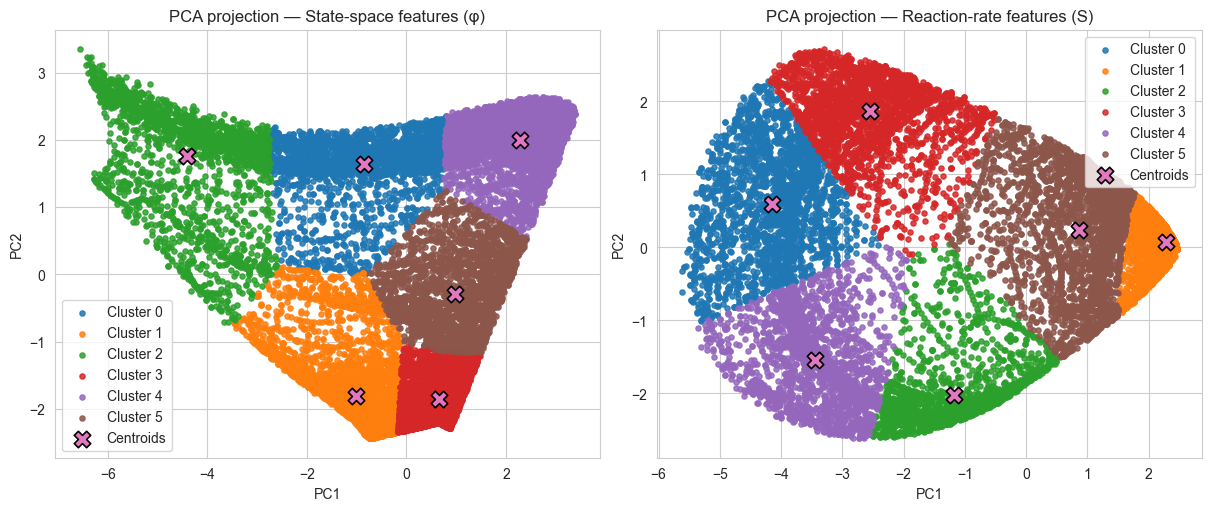

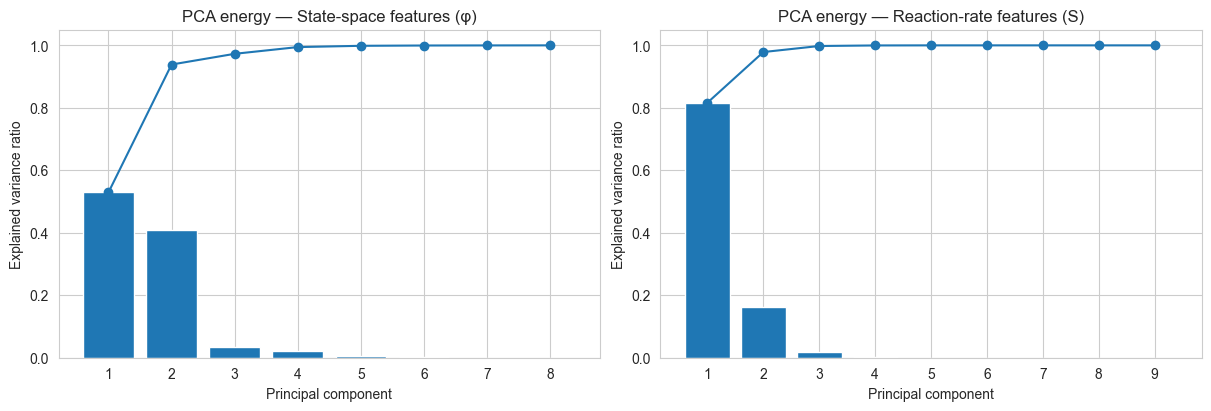

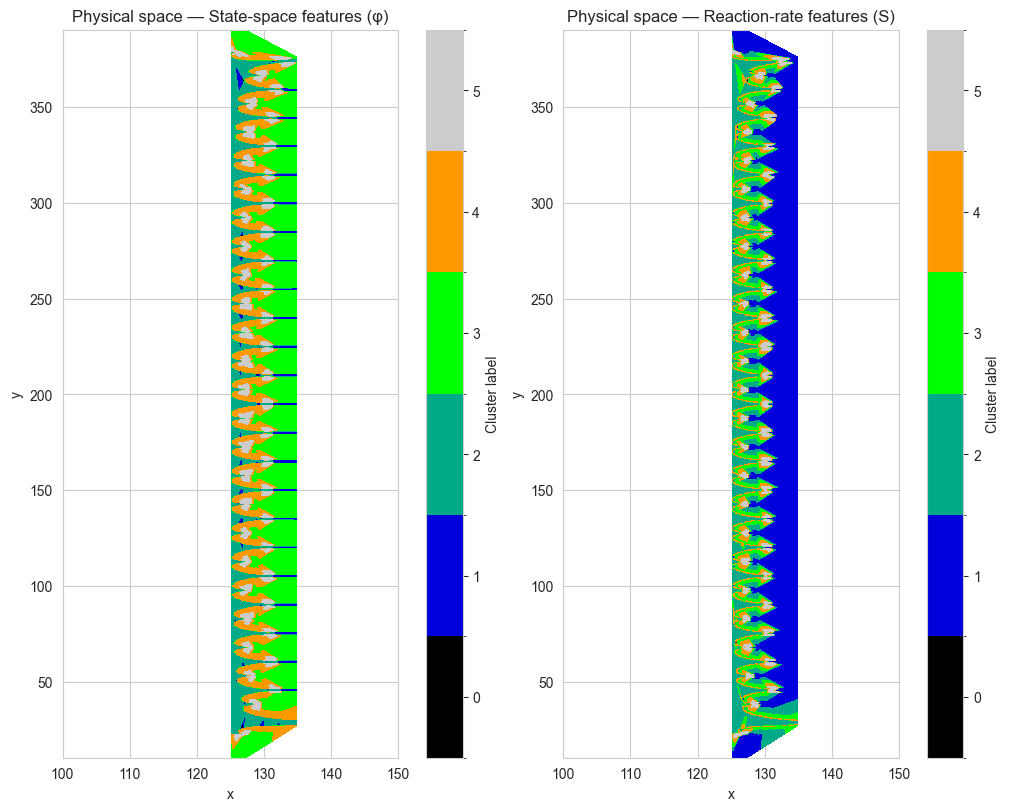

In [4]:
from sklearn.decomposition import PCA
# --- Pre-create side-by-side figures (left=state features, right=rate features) ---
fig_pca,   axs_pca   = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
fig_scree, axs_scree = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
fig_phys,  axs_phys  = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)

col_titles = {0: "State-space features (φ)", 1: "Reaction-rate features (S)"}

import matplotlib.tri as mtri
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib as mat

# Triangulation of fixed physical coordinates (reuse for both feature settings)
tri = mtri.Triangulation(df['x'].to_numpy(), df['y'].to_numpy())

for feature_setting in range(2):
    if feature_setting == 0:
        features = [
            'H2', 'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2'
        ]
    else:
        features = [
            'omega_H2', 'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH',
            'omega_HO2', 'omega_H2O2', 'omega_N2'
        ]

    X_raw = df[features].to_numpy()
    k = 6
    pipe = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        KMeans(n_clusters=k, init="k-means++", n_init="auto", max_iter=300, random_state=0)
    )
    labels = pipe.fit_predict(X_raw)

    # Pull out scaler and centroids (centroids are in scaled space)
    scaler = pipe.named_steps["standardscaler"]
    centroids_scaled   = pipe.named_steps["kmeans"].cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids_scaled)
    print(f"[{col_titles[feature_setting]}] Centroids in original feature units:\n", centroids_unscaled)

    # Optional: quality metric
    X_scaled = scaler.transform(X_raw)

    # ===== PCA for visualization (fit on scaled data seen by KMeans) =====
    pca = PCA(n_components=None, random_state=0)
    X2d        = pca.fit_transform(X_scaled)            # (n, >=2)
    centroids2d = pca.transform(centroids_scaled)       # centroids in scaled space

    evr     = pca.explained_variance_ratio_
    cum_evr = np.cumsum(evr)
    print(f"\n[{col_titles[feature_setting]}] Explained variance ratio per component:")
    for i, (e, c) in enumerate(zip(evr, cum_evr), start=1):
        print(f"  PC{i:>2}: {e:7.4f}   (cumulative: {c:7.4f})")

    # ===== Plot A: PCA clusters (side-by-side) =====
    axp = axs_pca[feature_setting]
    for c in range(k):
        axp.scatter(
            X2d[labels == c, 0], X2d[labels == c, 1],
            s=14, alpha=0.85, label=f"Cluster {c}"
        )
    axp.scatter(
        centroids2d[:, 0], centroids2d[:, 1],
        s=140, marker="X", edgecolor="k", linewidths=1.2, label="Centroids"
    )
    axp.set_title(f"PCA projection — {col_titles[feature_setting]}")
    axp.set_xlabel("PC1")
    axp.set_ylabel("PC2")
    axp.legend(loc="best")

    # ===== Plot B: Scree (side-by-side) =====
    axs = axs_scree[feature_setting]
    idx = np.arange(1, len(evr) + 1)
    axs.bar(idx, evr)
    axs.plot(idx, cum_evr, marker="o")
    axs.set_title(f"PCA energy — {col_titles[feature_setting]}")
    axs.set_xlabel("Principal component")
    axs.set_ylabel("Explained variance ratio")
    axs.set_xticks(idx)

    # ===== Plot C: Physical x–y map (side-by-side) — continuous categorical fill =====
    # --- choose a categorical colormap with exactly k distinct colors ---
    cmap = mat.colormaps.get_cmap('nipy_spectral')
    # --- discrete boundaries so each integer label maps to one color band ---
    bounds = np.arange(-0.5, k + 0.5, 1)
    norm   = BoundaryNorm(bounds, cmap.N)

    z = labels  # cluster labels (length n)

    # >>>>> THIS IS THE IMPORTANT CHANGE <<<<<
    ax_phys = axs_phys[feature_setting]  # use pre-created axis instead of new figure

    # Option 1: use triangulation (slightly cleaner)
    c = ax_phys.tricontourf(tri, z, levels=bounds, cmap=cmap, norm=norm)

    # Attach colorbar to fig_phys, but only for this axis
    cb = fig_phys.colorbar(c, ax=ax_phys, ticks=np.arange(k))
    cb.set_label("Cluster label")

    ax_phys.set_xlabel("x")
    ax_phys.set_ylabel("y")
    ax_phys.set_xlim(100, 150)  # optional window
    ax_phys.set_title(f"Physical space — {col_titles[feature_setting]}")

# --- Render all figures once, side-by-side comparisons ready ---
plt.show()




## Implement JSK means clustering

In [18]:
import numpy as np
from sklearn.cluster import KMeans

class JacobianScaledKMeans:
    def __init__(self, n_clusters, jacobian_fn,
                 max_iter=100, tol=1e-4, burn_in_iter=50,
                 random_state=None):
        self.n_clusters = n_clusters
        self.jacobian_fn = jacobian_fn
        self.max_iter = max_iter
        self.tol = tol
        self.burn_in_iter = burn_in_iter
        self.random_state = random_state

    def fit(self, X):
        X = np.asarray(X)
        n_samples, n_features = X.shape

        # --- Burn-in with standard K-means ---
        km = KMeans(
            n_clusters=self.n_clusters,
            n_init=1,
            max_iter=self.burn_in_iter,
            random_state=self.random_state,
        )
        labels = km.fit_predict(X)
        centroids = km.cluster_centers_

        for it in range(self.max_iter):
            centroids_old = centroids.copy()

            # (b) Jacobian at each centroid
            A_list = [self.jacobian_fn(c) for c in centroids]  # each (m, d)

            # (c) Assignment step with JSK distance
            # distances: (n_samples, n_clusters)
            d2 = np.empty((n_samples, self.n_clusters))

            for k in range(self.n_clusters):
                A_k = A_list[k]          # (m, d)
                diff = X - centroids[k]  # (n_samples, d)
                # scaled = diff @ (A_k.T @ A_k)^T is possible too,
                # but we can go directly:
                scaled = diff @ A_k.T    # (n_samples, m)
                d2[:, k] = np.sum(scaled * scaled, axis=1)

            labels = np.argmin(d2, axis=1)

            # (d) Centroid update (standard mean in feature space)
            for k in range(self.n_clusters):
                mask = (labels == k)
                if np.any(mask):
                    centroids[k] = X[mask].mean(axis=0)
                # else: keep old centroid or reinitialize

            # (e) convergence
            shift = np.linalg.norm(centroids - centroids_old, axis=1).max()
            if shift < self.tol:
                break

        self.cluster_centers_ = centroids
        self.labels_ = labels
        return self


In [ ]:
JSK = JacobianScaledKMeans(n_clusters= 5, jacobian_fn=)